## Workbench

In [23]:
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.stats import dirichlet, pearsonr, poisson, rankdata, gaussian_kde
import sys
import pickle
import time
from multiprocessing import Pool,cpu_count
import pandas as pd
import itertools
from functools import partial
from sklearn.manifold import MDS,TSNE
import warnings

In [3]:
%matplotlib inline
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
from matplotlib import cm, ticker
from adjustText import adjust_text
warnings.filterwarnings("ignore")

## Load data

In [3]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print(msg, end='', flush=True)
        self.start_time=time.time()
    def stop(self,msg=''):
        if msg:
            print("{}: {:2f} seconds".format(msg,time.time()-self.start_time), flush=True)
        else:
            print("Elapsed time: {:2f} seconds".format(time.time()-self.start_time), flush=True)
    def check(self):
        return time.time()-self.start_time

tic=Stopwatch()

In [4]:
def load_date(filename):
    tic=Stopwatch()
    tic.go("Loading paper dates {} from disk...".format(filename))
    pkl_file = open(filename, 'rb')
    A=pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    tic.stop()
    return A

def load_hypergraph(size, filename):
    tic=Stopwatch()
    tic.go("Loading file {} from disk...".format(filename))
    pkl_file = open(filename, 'rb')
    (row,col) = pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    A=ssp.coo_matrix((np.ones(len(row),dtype=np.int8),(row,col)),shape=(size, max(col)+1),dtype=np.int8)
    tic.stop()
    return A

In [15]:
term = "concept"

In [162]:
tic.go('Loading citation data...')
citations=pickle.load(open('graph/citations.pkl','rb'),encoding='latin1')
tic.stop()

# Load hypergraphs
tic=Stopwatch()
G = load_hypergraph(11000, f'graph/{term}_hypergraph.pkl').tocsr()
paper_dates = load_date('graph/paper_dates.pkl')

Loading citation data...Elapsed time: 0.003086 seconds
Loading file graph/concept_hypergraph.pkl from disk...Elapsed time: 0.053064 seconds
Loading paper dates graph/paper_dates.pkl from disk...Elapsed time: 0.000596 seconds


In [163]:
thetas,_,times=pickle.load(open(f'Fitted_Model/block_model_openalex_{term}.pkl','rb'))

In [25]:
works_df = pd.read_csv("../novelty-toy-model/data/medline_works.csv")
# terms_df = pd.read_csv("data/medline_terms.csv")

In [46]:
works_df.head()

,id,doi,title,display_name,publication_year,publication_date,type,cited_by_count,language,journal,pmid
0,https://openalex.org/W2139986038,https://doi.org/10.1074/jbc.m003360200,Physical and Functional Interaction between p5...,Physical and Functional Interaction between p5...,2000,2000-09-01,article,234,en,Journal of Biological Chemistry,10884390.0
1,https://openalex.org/W2068841581,https://doi.org/10.1016/s0738-3991(00)00120-8,Palliative care in chronic psycho-geriatrics: ...,Palliative care in chronic psycho-geriatrics: ...,2000,2000-08-01,article,15,en,Patient Education and Counseling,10900372.0
2,https://openalex.org/W4300009224,NaN,Special issue in honour of Eduard Kellenberger.,Special issue in honour of Eduard Kellenberger.,2001,2001-01-01,article,0,en,PubMed,10900373.0
3,https://openalex.org/W2074649876,https://doi.org/10.1016/s0968-4328(00)00024-x,Making science in a fractal landscape,Making science in a fractal landscape,2001,2001-01-01,article,2,en,Micron,10900375.0
4,https://openalex.org/W1971008052,https://doi.org/10.1016/s0968-4328(00)00029-9,Cryosubstitution of frozen biological specimen...,Cryosubstitution of frozen biological specimen...,2001,2001-01-01,review,27,en,Micron,10900376.0


In [23]:
with open(f'../novelty-toy-model/Results/novelty/novelty_openalex_{term}_results.pkl','rb') as infile:
     dfs1,years=pickle.load(infile)

In [4]:
with open(f'Results/novelty_medline_results.pkl','rb') as infile:
     dfs2,years=pickle.load(infile)

In [4]:
with open(f'Results/novelty_medline_results.pkl','rb') as infile:
     dfs,years=pickle.load(infile)

In [5]:
dfs = pd.concat(dfs, ignore_index=True)

In [8]:
dfs.to_csv("data/novelty_medline_results.csv")

In [27]:
dfs1 = pd.concat(dfs1, ignore_index=True)
dfs2 = pd.concat(dfs2, ignore_index=True)

In [53]:
works_df.loc[2]

id                                 https://openalex.org/W4300009224
doi                                                             NaN
title               Special issue in honour of Eduard Kellenberger.
display_name        Special issue in honour of Eduard Kellenberger.
publication_year                                               2001
publication_date                                         2001-01-01
type                                                        article
cited_by_count                                                    0
language                                                         en
journal                                                      PubMed
pmid                                                     10900373.0
Name: 2, dtype: object

In [28]:
from tqdm import tqdm

openalex_scores = []
original_scores = []
pmow = dfs2[dfs2['time'] == 2001]
pmoa = dfs1[dfs1['time'] == 2001]

for idx, row in tqdm(pmoa.iterrows()):
    try:
        oa_score = row['sM']
        pmid = works_df.loc[row['ID']]['pmid']
        ow_score = float(pmow[pmow['ID'] == int(pmid)]['sM'].values[0])
        openalex_scores.append(oa_score)
        original_scores.append(ow_score)
    except:
        continue

898it [00:00, 2000.95it/s]


In [94]:
ow_score = pmow[pmow['ID'] == int(10900373.0)]['sM'].values
float(ow_score[0])

1.0000000000000002

In [29]:
print(openalex_scores[0: 5])
print(original_scores[0: 5])

[6.957184867643672e-05, 4.645621854337541e-12, 8.152726032279908e-29, 5.3939113363761555e-42, 8.1248067268222155e-19]
[1.0000000000000002, 0.02607346122036939, 0.17626185216199572, 0.0014064868503289888, 0.17297634040655324]


In [30]:
from scipy.stats import pearsonr

# Assuming novelty_model1 and novelty_model2 are aligned and comparable
pearson_corr, pearson_p_value = pearsonr(np.array(openalex_scores), np.array(original_scores))

print(f'Pearson Correlation: Coefficient={pearson_corr:.4f}, p-value={pearson_p_value:.4f}')

Pearson Correlation: Coefficient=0.1774, p-value=0.0000


In [61]:
dfs2[dfs2['time'] == 2001].head()

,ID,time,cites,hit,terms,sM,refs,sJ
10057935,10880515,2001,31.0,True,8,0.000778,19,3.068687e-21
10057936,10880516,2001,13.0,False,7,0.000629,13,1.815280e-13
10057937,10884390,2001,24.0,False,7,0.001199,13,5.919486e-15
10057938,10900372,2001,0.0,False,1,1.000000,0,NaN
10057939,10900373,2001,0.0,False,1,1.000000,0,NaN


In [67]:
dfs1.head()

,ID,time,cites,hit,terms,sM
0,2,2001,0,False,4,6.957185e-05
1,3,2001,2,False,9,4.645622e-12
2,4,2001,27,False,21,8.152726e-29
3,5,2001,58,False,26,5.393911e-42
4,6,2001,22,False,13,8.124807e-19


In [33]:
novelty_model1 = np.array(openalex_scores)
novelty_model2 = np.array(original_scores)

In [23]:
filtered_works_df = works_df[(works_df["publication_year"] >= 2011) & (works_df["publication_year"] <= 2020)]
dfs["work_id"] = filtered_works_df["id"].reset_index(drop=True)
dfs["journal"] = filtered_works_df["journal"].reset_index(drop=True)

In [6]:
novelty_scores = dfs

In [7]:
novelty_scores.head()

,ID,time,cites,hit,terms,sM,refs,sJ
0,4100072,1966,0.0,False,3,5.395779e-02,0,NaN
1,4100747,1966,0.0,False,5,2.743299e-03,0,NaN
2,4100748,1966,0.0,False,1,1.000000e+00,0,NaN
3,4106591,1966,0.0,False,7,1.575028e-07,0,NaN
4,4106592,1966,0.0,False,5,1.076733e-02,0,NaN


In [8]:
novelty_scores = novelty_scores.rename(columns={"publication_year": "time"})

In [9]:
novelty_scores = novelty_scores.rename(columns={"sM": "novelty"})

In [10]:
novelty_scores = novelty_scores.rename(columns={"cites": "citation"})

In [29]:
novelty_scores.to_csv(f"data/novelty_scores_{term}.csv", index=False)

In [30]:
len(novelty_scores["journal"].unique())

3

In [38]:
novelty_scores.columns

Index(['ID', 'time', 'citation', 'hit', 'terms', 'novelty', 'refs', 'sJ'], dtype='object')

## Results

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load the dataframes
works_df = pd.read_csv("data/medline_works.csv")
terms_df = pd.read_csv("data/medline_terms.csv")

novelty_scores = pd.read_csv(f"data/novelty_scores_{term}.csv")

# Merge the dataframes
merged_df = pd.merge(novelty_scores, terms_df, left_on='work_id', right_on='work_id')

In [224]:
merged_df = pd.merge(novelty_scores, concepts_df, left_on='work_id', right_on='work_id')

In [222]:
merged_df = pd.merge(merged_df, works_df, left_on='work_id', right_on='id')


In [11]:
merged_df = novelty_scores

In [18]:
merged_df['novelty'] = -np.log(merged_df.novelty)

In [21]:
merged_df.columns

Index(['ID', 'time', 'citation', 'hit', 'terms', 'novelty', 'refs', 'sJ'], dtype='object')

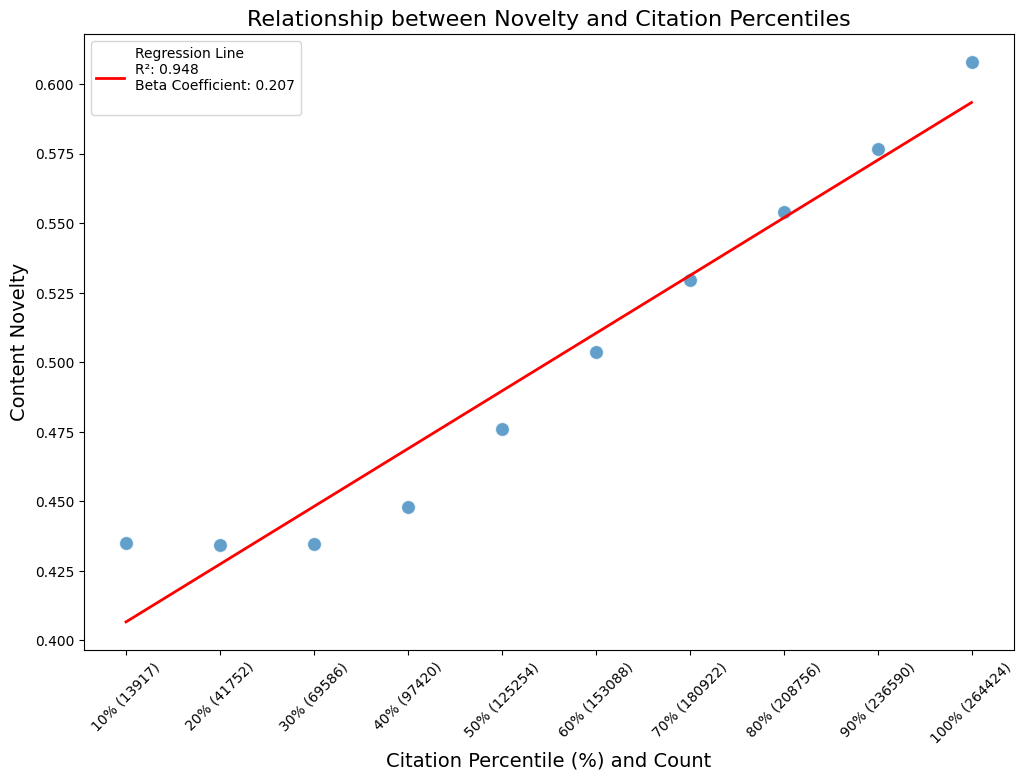

In [19]:
import random
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata

# Initialize lists to store combined data
X_m = []
Y_m = []
Z_m = []
Z_mn = []

# Loop over each year from 1966 to 2000
for year in range(1966, 2000):
    # Filter dataframe for the selected year
    sampled_df = merged_df[merged_df['time'] == year]

    # Drop NaN values for citation and novelty
    sampled_df = sampled_df.dropna(subset=['citation', 'novelty'])

    # Add a small random noise to citation to avoid ties
    sampled_df['citation'] += np.random.normal(0, 1e-10, len(sampled_df['citation']))

    # Calculate percentiles using ranking and binning
    # Binning citation into 10 bins
    sampled_df['citation_bins'] = pd.qcut(sampled_df['citation'], 10, labels=False)

    # Convert citation and novelty to percentiles using rankdata
    sampled_df['citation_percentile'] = (rankdata(sampled_df['citation']) - 1) / (len(sampled_df) - 1)
    sampled_df['citation_percentile_n'] = rankdata(sampled_df['citation'])
    sampled_df['novelty_percentile'] = (rankdata(-np.log(sampled_df['novelty'])) - 1) / (len(sampled_df) - 1)

    # Append data to combined lists
    X_m.extend(sampled_df['citation_bins'])
    Y_m.extend(sampled_df['novelty_percentile'])
    Z_m.extend(sampled_df['citation_percentile'])
    Z_mn.extend(sampled_df['citation_percentile_n'])

# Convert lists to numpy arrays
X_m = np.array(X_m)
Y_m = np.array(Y_m)
Z_m = np.array(Z_m)
Z_mn = np.array(Z_mn)

# Aggregate data by citation_bins
content = pd.DataFrame({'X': X_m, 'Y': Y_m, 'Z': Z_m, 'Zn': Z_mn})
content_agg = content.groupby('X').agg([np.mean, np.std, len])
content_agg = content_agg.reset_index()

# Extract the mean values of citation and novelty percentiles from the aggregated DataFrame
citation_mean = content_agg['Z']['mean'].values.reshape(-1, 1)  # Mean citation percentile
novelty_mean = content_agg['Y']['mean'].values  # Mean novelty percentile

# Fit linear regression model to the mean percentiles
X = citation_mean
y = novelty_mean
model = LinearRegression().fit(X, y)
predictions = model.predict(X)

# Create x-axis labels showing percentile and mean count
x_labels = [f"{int((i+1)*10)}% ({int(content_agg['Zn']['mean'].iloc[i])})" for i in range(len(content_agg))]

# Plot mean novelty percentile against mean citation percentile
plt.figure(figsize=(12, 8))

# Plot scatterplot of the data points
sns.scatterplot(x=range(len(content_agg)), y=novelty_mean, alpha=0.7, s=100)

# Plot regression line
sns.lineplot(x=range(len(content_agg)), y=predictions, color='red', label=f'Regression Line\nR²: {r2_score(y, predictions):.3f}\nBeta Coefficient: {model.coef_[0]:.3f}\n', linewidth=2)

# Customize plot
plt.title(f'Relationship between Novelty and Citation Percentiles', fontsize=16)
plt.ylabel('Content Novelty', fontsize=14)
plt.xlabel('Citation Percentile (%) and Count', fontsize=14)
plt.xticks(ticks=range(len(content_agg)), labels=x_labels, rotation=45)
plt.show()


Accuracy: 0.98
Precision: 0.96
Recall: 0.94
F1 Score: 0.95
AUC-ROC: 0.96
Log Loss: 0.65


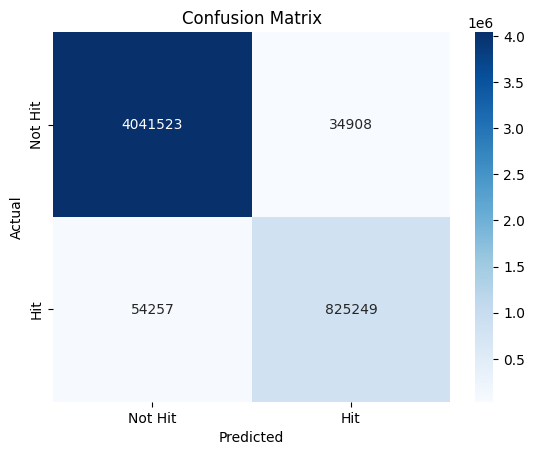

In [32]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    confusion_matrix,
)

# Initialize lists to store combined data
novelty_scores = []
citation_scores = []
hit_labels = []

# Loop over each year from 1966 to 2000
for year in range(1966, 2000):
    # Filter dataframe for the selected year
    sampled_df = merged_df[merged_df['time'] == year]

    # Drop NaN values for citation, novelty, and hit
    sampled_df = sampled_df.dropna(subset=['citation', 'novelty', 'hit', 'sJ'])

    # Append actual citation, novelty values and hit labels to combined lists
    citation_scores.extend(sampled_df['citation'])
    novelty_scores.extend(sampled_df['novelty'])
    hit_labels.extend(sampled_df['hit'])

# Convert lists to numpy arrays
citation_scores = np.array(citation_scores).reshape(-1, 1)
novelty_scores = np.array(novelty_scores).reshape(-1, 1)
hit_labels = np.array(hit_labels)

# Combine citation and novelty scores for logistic regression input
X = np.hstack((citation_scores, novelty_scores))
y = hit_labels

# Fit logistic regression model to the data
model = LogisticRegression()
model.fit(X, y)

# Predict probabilities for logistic regression
y_pred_prob = model.predict(X)

# Sorting the predicted probabilities and actual values for plotting
sorted_indices = np.argsort(y_pred_prob)
y_sorted = y[sorted_indices]
y_pred_prob_sorted = y_pred_prob[sorted_indices]

y_pred = y_pred_prob_sorted
y = y_sorted
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)
log_loss_value = log_loss(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")
print(f"Log Loss: {log_loss_value:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hit', 'Hit'], yticklabels=['Not Hit', 'Hit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


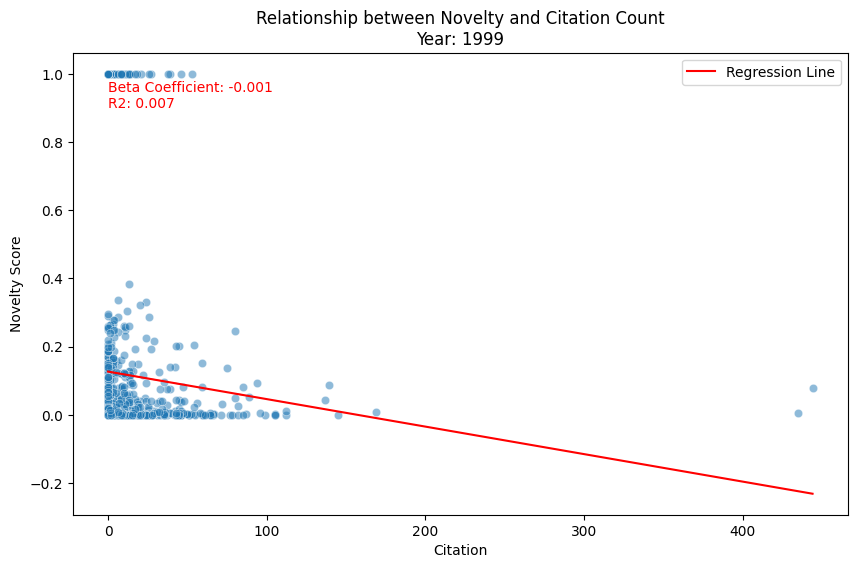

In [13]:
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Select a specific publication year and field
selected_year = 1999

sampled_df = merged_df[(merged_df['time'] == selected_year)]

sampled_df = sampled_df.sample(n=1000, random_state=42)

sampled_df = sampled_df.dropna(subset=['citation', 'novelty'])

# Scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_df, x='citation', y='novelty', alpha=0.5)

# Fit regression line
X = sampled_df['citation'].values.reshape(-1, 1)
y = sampled_df['novelty'].values
model = LinearRegression().fit(X, y)
predictions = model.predict(X)

# Plot regression line
sns.lineplot(x=sampled_df['citation'], y=predictions, color='red', label='Regression Line')
plt.title(f'Relationship between Novelty and Citation Count\nYear: {selected_year}')
plt.ylabel('Novelty Score')
plt.xlabel('Citation')

# Annotate plot with R2 and beta coefficient
beta_coef = model.coef_[0]
r_squared = r2_score(y, predictions)
plt.text(0.1, max(y)*0.9, f'Beta Coefficient: {beta_coef:.3f}\nR2: {r_squared:.3f}', color='red')

plt.show()


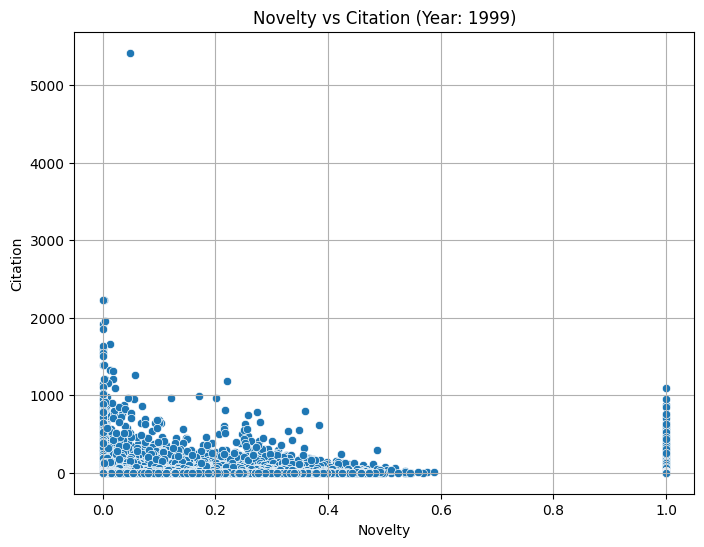

In [12]:
year = 1999
df_2007 = merged_df[merged_df['time'] == year]

# Plot novelty against citation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_2007, x='novelty', y='citation', marker='o')

# Add labels and title
plt.ylabel('Citation')
plt.xlabel('Novelty')
plt.title(f'Novelty vs Citation (Year: {year})')
plt.grid(True)

# Display the plot
plt.show()

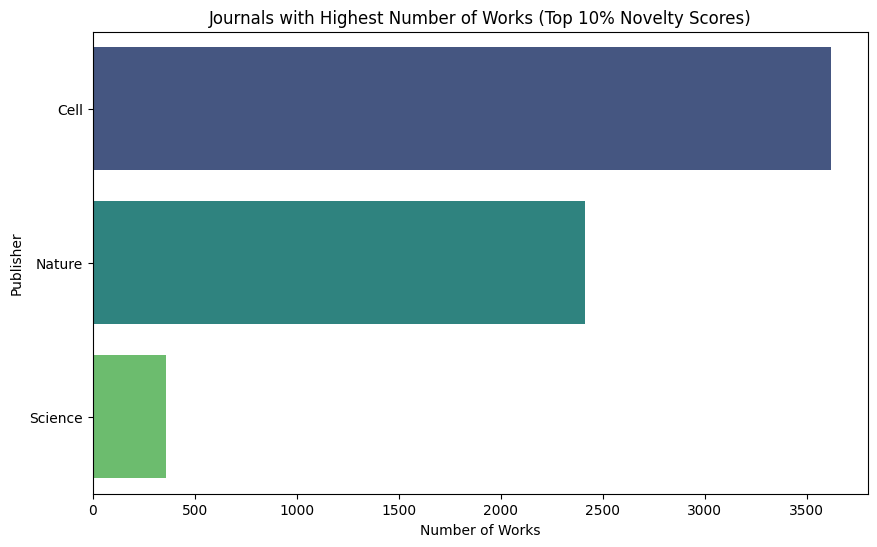

In [34]:
percentile_90 = merged_df['novelty'].quantile(0.9)

filtered_df = merged_df[merged_df['novelty'] >= percentile_90]

publisher_counts = filtered_df.groupby('journal').size().reset_index(name='work_count')

top_publishers = publisher_counts.sort_values(by='work_count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='work_count', y='journal', data=top_publishers, palette='viridis')
plt.title('Journals with Highest Number of Works (Top 10% Novelty Scores)')
plt.xlabel('Number of Works')
plt.ylabel('Publisher')
plt.show()


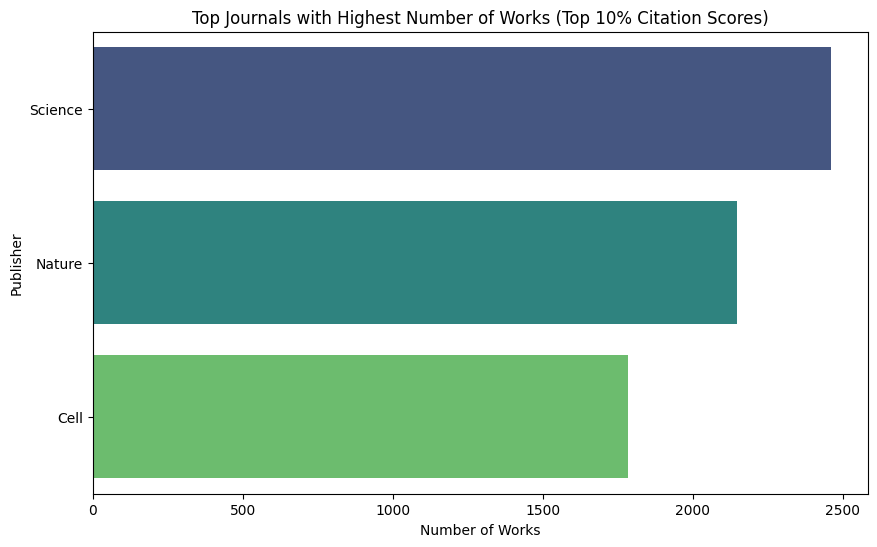

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
# Step 1: Calculate the 90th percentile of the 'citation' column
percentile_90 = merged_df['citation'].quantile(0.9)

# Step 2: Filter the DataFrame for citation scores in the top 10% percentile
filtered_df = merged_df[merged_df['citation'] >= percentile_90]

# Step 3: Group by 'publisher' and count the number of works
publisher_counts = filtered_df.groupby('journal').size().reset_index(name='work_count')

# Step 4: Sort and select the top 10 publishers
top_publishers = publisher_counts.sort_values(by='work_count', ascending=False).head(10)

# Step 5: Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='work_count', y='journal', data=top_publishers, palette='viridis')
plt.title('Top Journals with Highest Number of Works (Top 10% Citation Scores)')
plt.xlabel('Number of Works')
plt.ylabel('Publisher')
plt.show()


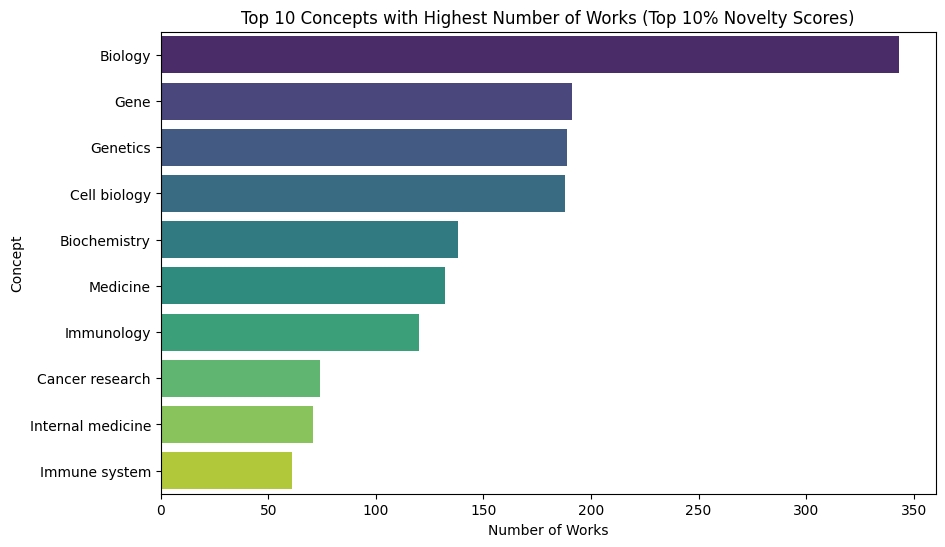

In [37]:
percentile_90 = merged_df['novelty'].quantile(0.9)

filtered_df = merged_df[merged_df['novelty'] >= percentile_90]

publisher_counts = filtered_df.groupby('display_name').size().reset_index(name='work_count')

top_publishers = publisher_counts.sort_values(by='work_count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='work_count', y='display_name', data=top_publishers, palette='viridis')
plt.title('Top 10 Concepts with Highest Number of Works (Top 10% Novelty Scores)')
plt.xlabel('Number of Works')
plt.ylabel('Concept')
plt.show()

In [236]:
merged_df.shape

(101693, 18)

In [235]:
import pandas as pd

percentile_90 = merged_df['novelty'].quantile(0.9)

filtered_df = merged_df[merged_df['novelty'] >= percentile_90]

number_of_works = filtered_df.shape

print("Number of works in the top 10% novelty:", number_of_works)


Number of works in the top 10% novelty: (10171, 18)


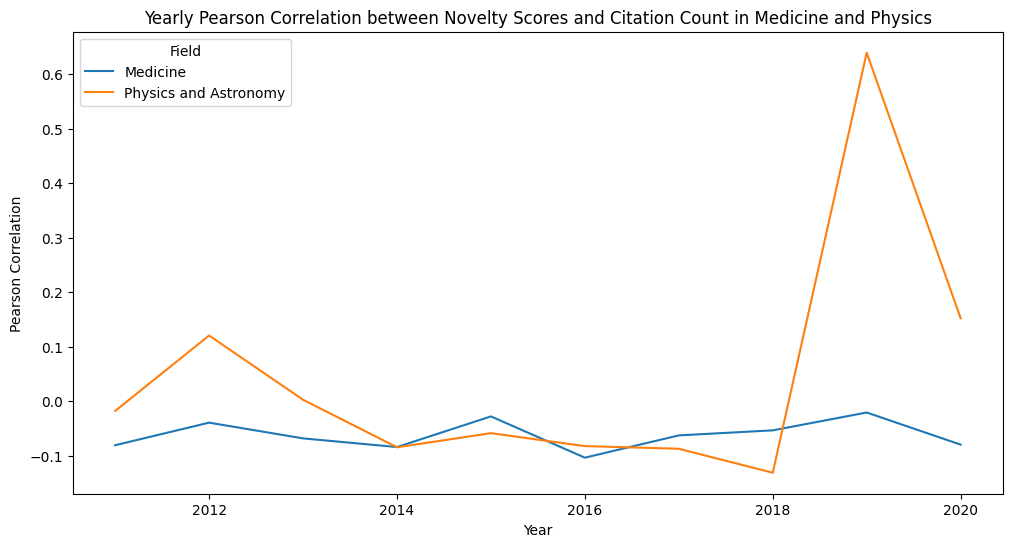

In [157]:
# Filter for only Medicine and Physics fields
filtered_df = merged_df[merged_df['field_display_name'].isin(['Medicine', 'Physics and Astronomy'])]

# Group by year and field, then compute Pearson correlation
yearly_correlations = []
for (year, field), group in filtered_df.groupby(['time', 'field_display_name']):
    if len(group) > 1:
        corr, _ = pearsonr(group['novelty'], group['citation'])
        yearly_correlations.append({'year': year, 'field': field, 'correlation': corr})

correlation_df = pd.DataFrame(yearly_correlations)

# Plot yearly results
plt.figure(figsize=(12, 6))
sns.lineplot(data=correlation_df, x='year', y='correlation', hue='field')
plt.title('Yearly Pearson Correlation between Novelty Scores and Citation Count in Medicine and Physics')
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.legend(title='Field')
plt.show()


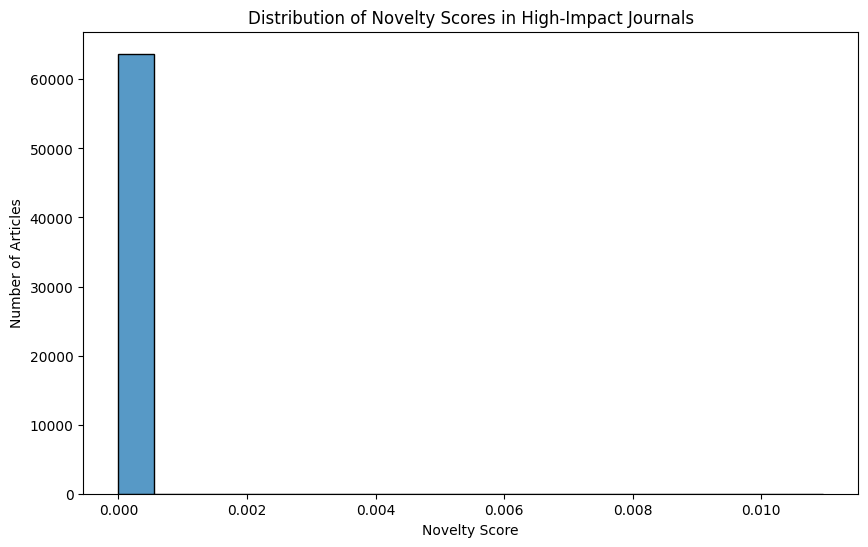

journal
Cell       4.936268e-16
Nature     1.088980e-18
Science    2.493886e-25
Name: novelty, dtype: float64


In [42]:
high_impact_publishers = ['Science', 'Nature', 'Cell']
filtered_df = merged_df[merged_df['journal'].isin(high_impact_publishers)]

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['novelty'], bins=20, kde=False)
plt.title('Distribution of Novelty Scores in High-Impact Journals')
plt.xlabel('Novelty Score')
plt.ylabel('Number of Articles')
plt.show()

# Calculate median novelty score for high-impact publishers
median_novelty_scores = filtered_df.groupby('journal')['novelty'].median()
print(median_novelty_scores)


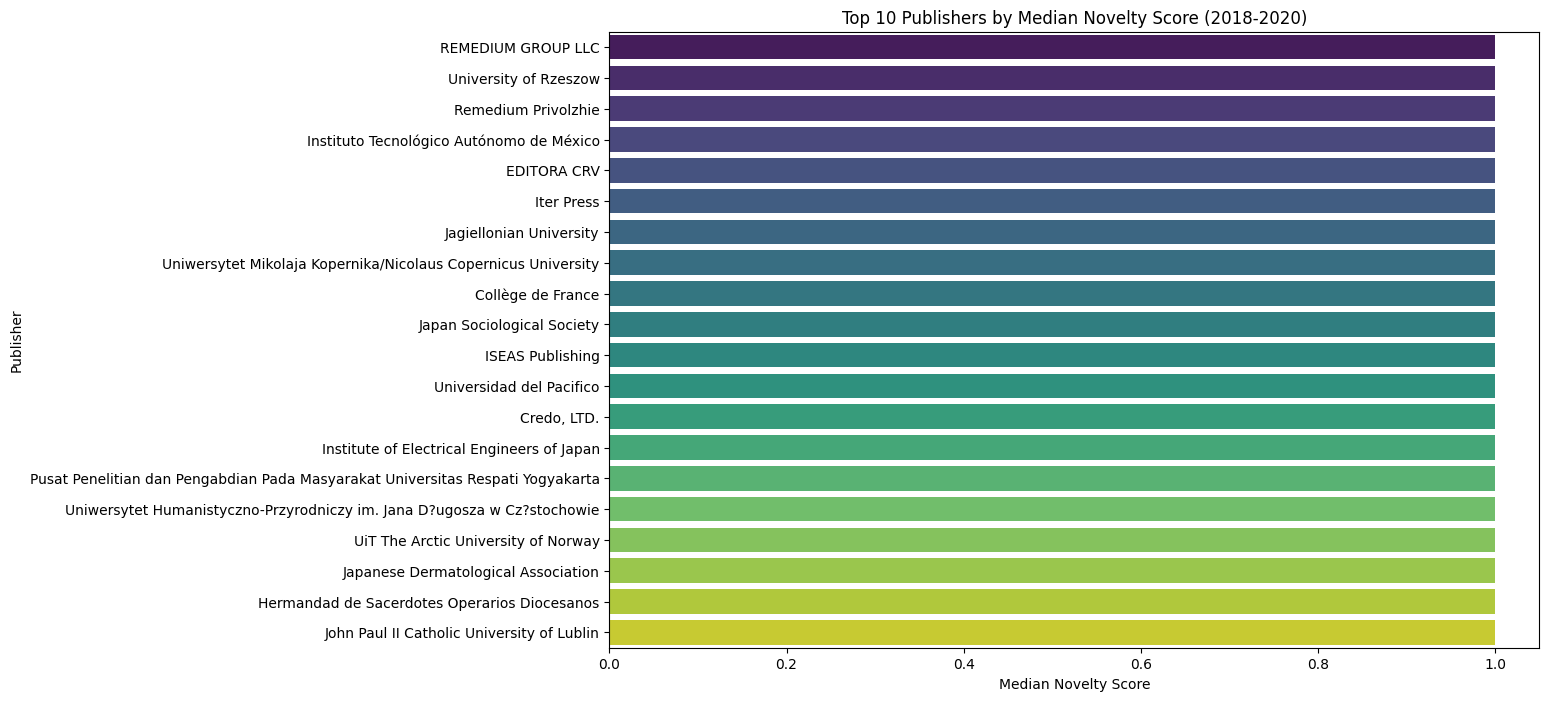

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for the desired time interval (e.g., 2018-2020)
selected_interval = merged_df[(merged_df['time'] >= 2011) & 
                              (merged_df['time'] <= 2020)]

# Calculate the median novelty score for each publisher
median_novelty_by_publisher = selected_interval.groupby('publisher')['novelty'].median().sort_values(ascending=False)

# Count the number of works for each publisher
work_counts = selected_interval['publisher'].value_counts()

# Combine the results into a single dataframe
ranking_df = pd.DataFrame({
    'Publisher': median_novelty_by_publisher.index,
    'Median Novelty Score': median_novelty_by_publisher.values
}).reset_index(drop=True)

# Add the number of works to the dataframe
ranking_df['Number of Works'] = ranking_df['Publisher'].map(work_counts)

# Get the top 10 publishers by median novelty score
top_10_publishers = ranking_df.head(20)

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Median Novelty Score', y='Publisher', data=top_10_publishers, palette='viridis')

# Add labels and title
plt.xlabel('Median Novelty Score')
plt.ylabel('Publisher')
plt.title('Top 10 Publishers by Median Novelty Score (2018-2020)')
plt.show()


In [160]:
# Drop NaN values in the 'novelty' column from the merged dataframe
# merged_df = merged_df.dropna(subset=['novelty'])
# merged_df = merged_df.dropna(subset=['field_display_name'])

# Filter for high-impact journals and selected years
high_impact_publishers = ['Science', 'Nature', 'Cell']  # Example publishers, replace with your list
filtered_df = merged_df[
    (merged_df['time'].between(2011, 2020))
]

# Calculate % of hit papers
hit_papers_percentage = filtered_df['hit'].mean() * 100
print(f'Percentage of Hit Papers: {hit_papers_percentage:.2f}%')

# Check if hit_papers_percentage is not NaN
if pd.notna(hit_papers_percentage):
    # Convert the percentage to a quantile value (between 0 and 1)
    quantile_value = hit_papers_percentage / 100
    
    # Calculate equivalent novelty score for the same % of hit papers
    equivalent_novelty_score = merged_df[
        (merged_df['time'].between(2011, 2020)) & 
        (merged_df['hit'] == True)
    ].groupby('field_display_name')['novelty'].quantile(quantile_value)

    print(equivalent_novelty_score)
else:
    print("Hit papers percentage calculation resulted in NaN.")



Percentage of Hit Papers: 10.62%
field_display_name
Agricultural and Biological Sciences            7.648133e-30
Arts and Humanities                             7.456673e-18
Biochemistry, Genetics and Molecular Biology    3.563757e-28
Business, Management and Accounting             3.051557e-27
Chemical Engineering                            1.233839e-20
Chemistry                                       7.061488e-26
Computer Science                                1.022328e-28
Decision Sciences                               6.921319e-33
Dentistry                                       9.282662e-24
Earth and Planetary Sciences                    3.177271e-27
Economics, Econometrics and Finance             8.027683e-27
Energy                                          9.249736e-32
Engineering                                     3.582544e-32
Environmental Science                           1.012640e-32
Health Professions                              4.226126e-25
Immunology and Microbiology      

### Novelty and hit paper

In [13]:
from novelty import novelty_and_hit_paper, novelty_and_citation, citation_and_novelty

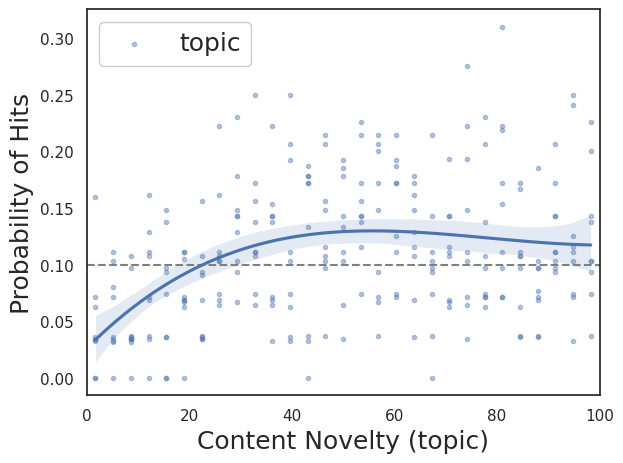

(PearsonRResult(statistic=0.3010232338982717, pvalue=7.223787612660956e-07),
 'Results/novelty/plots/content_novelty_and_hit_paper_topic.png')

In [8]:
novelty_and_hit_paper(dfs, years, term, display=True)

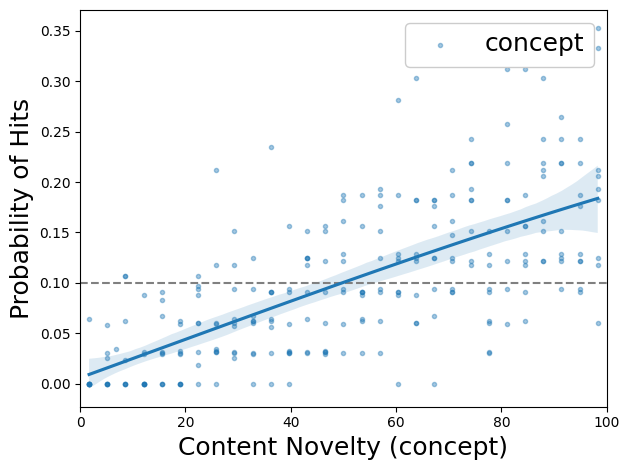

(PearsonRResult(statistic=0.6897978383008793, pvalue=4.6561922715620394e-38),
 'Results/novelty/plots/content_novelty_and_hit_paper_concept.png')

In [14]:
novelty_and_hit_paper(dfs, years, term, display=True)

### Novelty vs citation

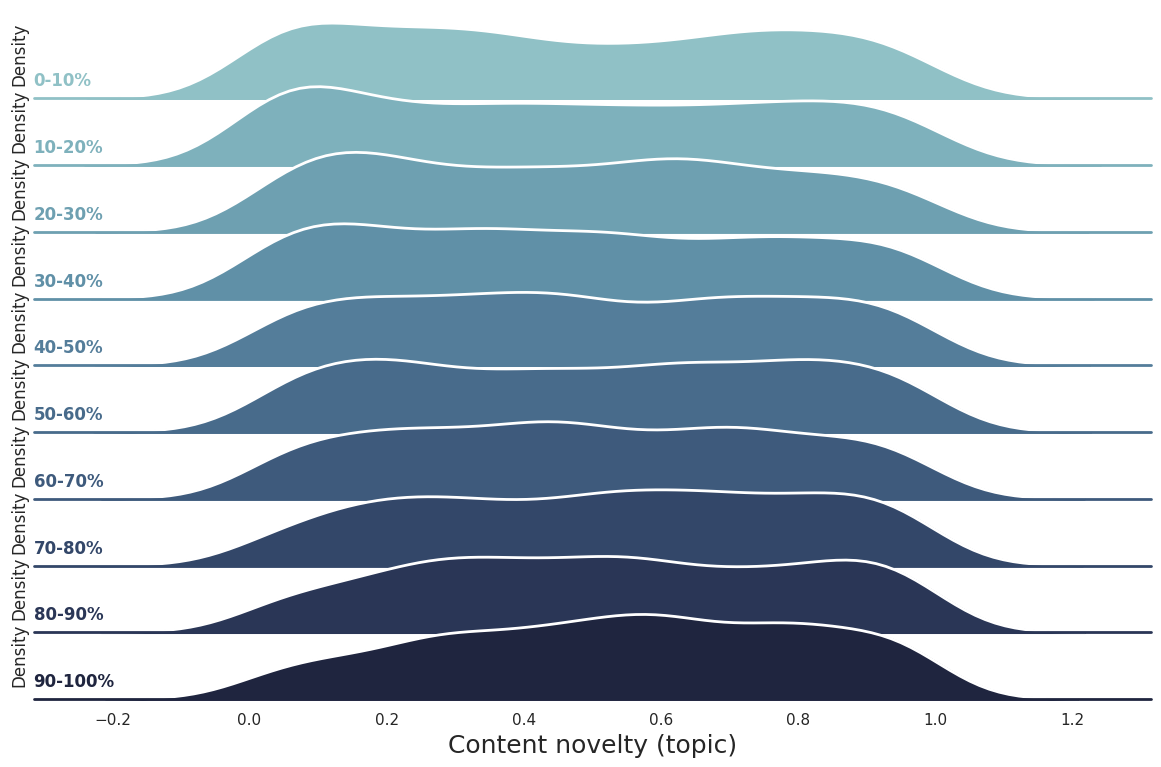

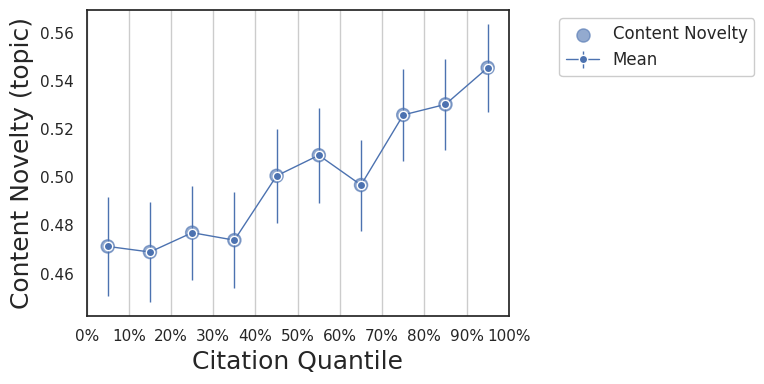

(PearsonRResult(statistic=0.9506144517499265, pvalue=2.451345903538474e-05),
 'Results/novelty/plots/content_vs_citation_density_distribution_topic.png',
 'Results/novelty/plots/content_vs_citations_quantile_topic.png')

In [11]:
novelty_and_citation(dfs, term, True)

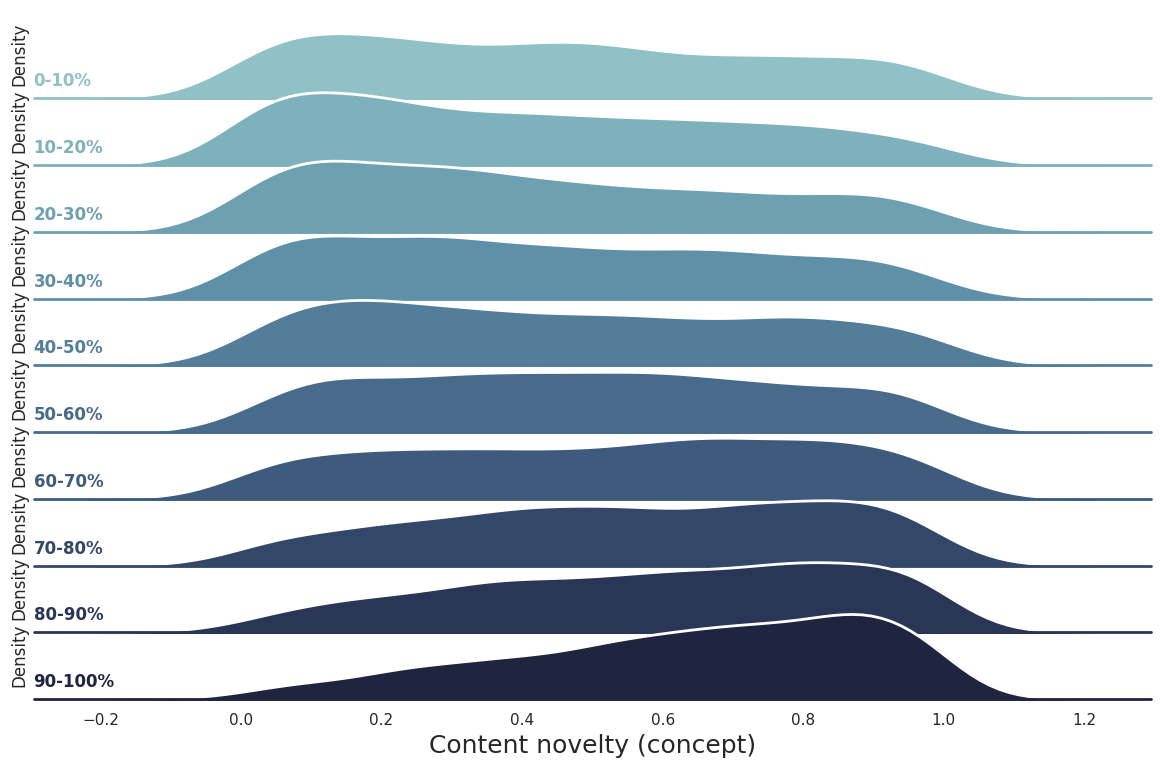

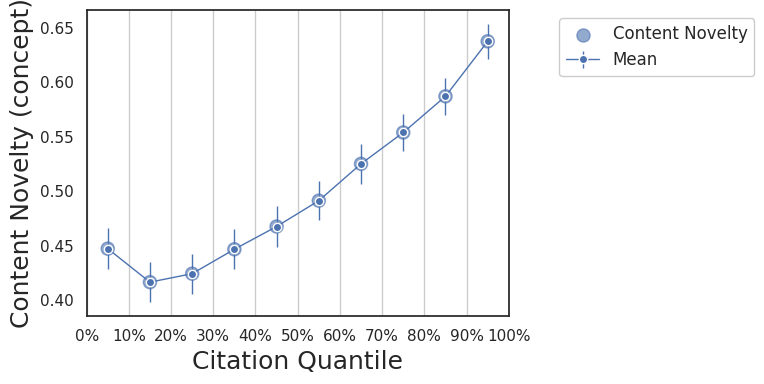

(PearsonRResult(statistic=0.9436632720926386, pvalue=4.116020149716111e-05),
 'Results/novelty/plots/content_vs_citation_density_distribution_concept.png',
 'Results/novelty/plots/content_vs_citations_quantile_concept.png')

In [15]:
novelty_and_citation(dfs, term, True)

### Citation vs novelty

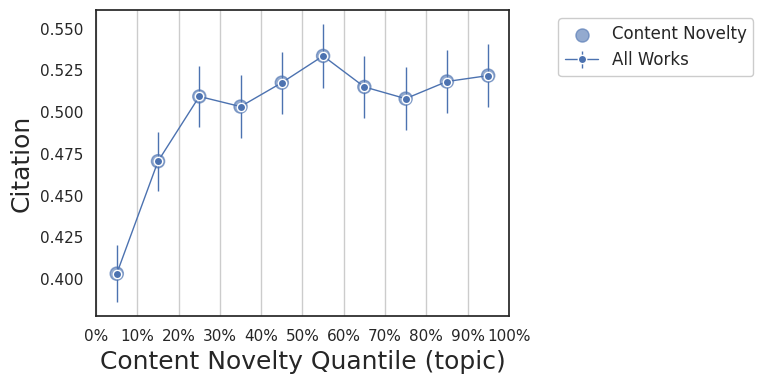

'Results/novelty/plots/citation_vs_content_quantile_topic.png'

In [12]:
citation_and_novelty(dfs, term, True)

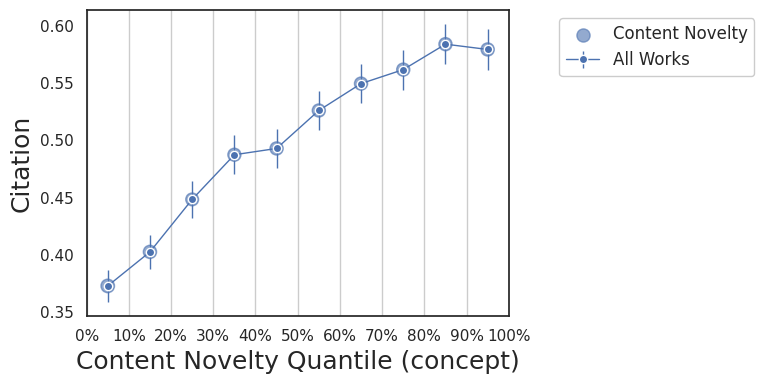

'Results/novelty/plots/citation_vs_content_quantile_concept.png'

In [16]:
citation_and_novelty(dfs, term, True)